In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
pid = 193
qid = 7638
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

other_docs = Doc.objects.filter(docproject__project=p, PY__gt=2012).exclude(query=q)

for d in other_docs:
    d.query.add(q)

q.r_count = q.doc_set.count()
q.save()
q.r_count

75079

In [3]:
q.doc_set.filter(PY=2012).count()

5

In [4]:
docs = Doc.objects.filter(query=q, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

62586


8630

In [5]:
DocProject.objects.filter(project=p).values('relevant').annotate(
    n = Count('pk')
)

<QuerySet [{'relevant': 0, 'n': 106655}, {'relevant': 1, 'n': 3043}, {'relevant': 2, 'n': 5298}, {'relevant': 3, 'n': 319}]>

In [6]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(53956, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,46,Glaciers store water over a range of temporal ...,A review of methods for estimating the contrib...,climate change; glacier meltwater; hydrologica...,"[Geography, Physical; Geosciences, Multidiscip...",0,0
1,111,1 .Gradients in elevation are increasingly use...,Changes in host-parasitoid food web structure ...,climate change; elevation; experimental manipu...,[Ecology; Zoology],0,0
2,260,Phytosanitary risks are an increasing threat f...,An economic comparison of risk handling measur...,Phytosanitary risks; Cause-oriented measures; ...,[Forestry],0,0
3,274,Regenerative sustainability is emerging as an ...,Regenerative sustainability for the built envi...,Regenerative sustainability; Theory; Framework...,[Green & Sustainable Science & Technology; Eng...,0,0
4,297,Grass silage is typically fed to dairy cows in...,Effects of nitrogen fertilisation rate and mat...,nitrogen fertilisation; grass maturity; ryegra...,"[Agriculture, Dairy & Animal Science; Veterina...",0,0


In [7]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(8329, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,694,The effectiveness of various adaptation option...,Building adaptive capacity in South East Queen...,Adaptive capacity; Climate change; Adaptation;...,[Environmental Sciences; Environmental Studies],0,1
1,1630,Cover crops have long been touted for their ab...,Using cover crops to mitigate and adapt to cli...,Adaptive management; Agriculture; Albedo; Cove...,[Agronomy; Green & Sustainable Science & Techn...,1,1
2,1731,Management of marine mega-fauna in a changing ...,Adaptive management of marine mega-fauna in a ...,Adaptive management; Climate change; Marine me...,[Environmental Sciences],0,1
3,2382,According to dominant narratives about adaptat...,Migration Amidst Climate Rigidity Traps: Resou...,adaptation; climate change; migration; politic...,[Geography],0,1
4,3095,"Many coasts are eroding. In the Comoros, as in...",Seawalls as a response to coastal erosion and ...,Grande Comore; Comoros; Seawalls; Coastal eros...,[Environmental Sciences; Environmental Studies],1,1


In [8]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,725396,To explore the effects of sea level rise (SLR)...,Future vegetation patterns and primary product...,coastal ecosystem; sea level rise; exotic gras...,"[Environmental Sciences; Geosciences, Multidis...",0,0
1,1504777,AimPuzzling features of plants are sometimes e...,Climate predicts the proportion of divaricate ...,drought; frost; generalized additive model; me...,"[Ecology; Geography, Physical]",0,0
2,760948,Existing studies on adaptation to climate chan...,Gender Differences in Climate Change Adaptatio...,Perceptions; Adaptation; Group-based approache...,[Ecology; Economics; Environmental Sciences; E...,1,1
3,788341,Mexico gained worldwide reputation for its eff...,The interplay between climate change and disas...,Disaster risk reduction; policy interplay; cli...,[Environmental Studies],0,0
4,2463872,Ochratoxin A (OTA) is a nephrotoxic mycotoxin ...,Intraspecific variability of growth and ochrat...,Aspergillus carbonarius; Coffee; Ecophysiology...,[Food Science & Technology; Microbiology],0,0


In [9]:
duplicateRowsDF = df[df.duplicated(['title'])]
print(duplicateRowsDF.shape)

duplicateRowsDF.head()



(434, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
1400,2463943,Alpine plants occurring at high elevation are ...,Variation in growth and defence traits among p...,alpine; Arabis alpina; defence; elevation; env...,[Plant Sciences; Ecology],0,0
1821,2058811,Coffee is one of the most important tropical c...,Ecosystem services by birds and bees to coffee...,Agroforestry; Bees; Biodiversity; Birds; Coffe...,None,1,1
2447,2457670,"In many types of clouds, multiple hydrometeor ...",Development and validation of a supervised mac...,None,None,0,0
3861,2464027,Temperature in the progamic phase is critical ...,Influence of temperature on the progamic phase...,Pollen tube growth dynamics and kinetics; Stig...,[Plant Sciences; Environmental Sciences],0,0
4013,2463848,Human activities have fundamentally changed Ea...,Remote sensing of forest die-off in the Anthro...,Discoloration; Drought stress; Image fusion; I...,[Environmental Sciences; Remote Sensing; Imagi...,0,0


In [10]:
for i, row in duplicateRowsDF.iterrows():
    if len(row['title'].split()) < 3:
        print(row['title'])
        continue
    d = Doc.objects.get(pk=row['id'])
    ds = Doc.objects.filter(
        tslug=Doc.make_tslug(d.title),
        PY=d.PY
    )
    if ds.count() > 1:
        print(ds.values('title','id'))
        try:
            wd = ds.get(UT__UT__icontains="WOS:")
            sd = ds.exclude(UT__UT__icontains="WOS:")
        except:
            wd = ds.first()
            sd = ds.exclude(pk=wd.pk)
            #print(sd)
            #continue
        
        for d in sd:
            for do in d.docownership_set.filter(query__project=p):
                if DocOwnership.objects.filter(user=do.user,doc=do.doc).exists():
                    do.delete()
                else:
                    do.doc=wd
                    do.save()
            for q in d.query.filter(project=p):
                d.query.remove(q)
            try:
                DocProject.objects.get(doc=d,project=p).delete()
            except:
                pass
            
            dut = d.UT
            sid = dut.UT
            dut.UT = dut.UT+"dup"
            dut.save()
        wut = wd.UT
        wut.sid = sid
        wut.save()
            
        

Sustainability
Economics
Economics
Introduction
<QuerySet [{'title': 'Optimization Weather Parameters Influencing Rainfall Prediction Using Adaptive Network-based Fuzzy Inference Systems (ANFIS) and Linier Regression', 'id': 2390488}, {'title': 'Optimization Weather Parameters Influencing Rainfall Prediction Using Adaptive Network-based Fuzzy Inference Systems (ANFIS) and Linier Regression', 'id': 2390490}]>
Urban areas
Economics
<QuerySet [{'title': 'Some resilient aspects of urban areas to air pollution and climate change, case study: Tehran, Iran', 'id': 218323}, {'title': 'Some resilient aspects of urban areas to air pollution and climate change, case study: Tehran, Iran', 'id': 118712}]>
<QuerySet [{'title': 'Genomics of Developmental Plasticity in Animals', 'id': 2389223}, {'title': 'Genomics of Developmental Plasticity in Animals', 'id': 2328760}]>
Introduction
Preface
<QuerySet [{'title': 'Feasibility and performance study for a space-borne 1645 nm OPO for French-German satelli

In [11]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
#pred_index = pd.Index(random.sample(list(unseen_index),5000))

k = math.ceil(len(seen_index)*0.8)
train_index = pd.Index(random.sample(list(seen_index),k))

print(seen_index)
print(train_index)

#experiment_index = pd.Index(set(seen_index) | set(pred_index))

test_index = pd.Index([x for x in seen_index if x not in train_index])


Int64Index([    2,     7,    14,    27,    29,    32,    33,    39,    56,
               61,
            ...
            62240, 62243, 62246, 62247, 62248, 62251, 62254, 62256, 62261,
            62269],
           dtype='int64', length=8329)
Int64Index([50034, 20714, 45023, 11651, 16520, 58702, 22008, 33323,  5221,
            35965,
            ...
            19199, 61076, 38827, 43586, 32013, 18228, 31247, 56097, 32342,
            52471],
           dtype='int64', length=6664)


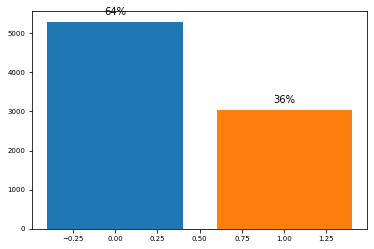

In [12]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

In [13]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=4, max_df=0.8, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

y = df['relevant']
ab_X = vec.fit_transform(df['content'])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


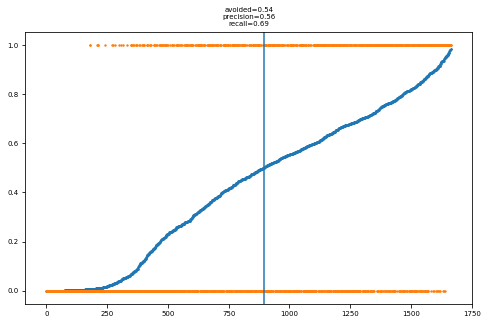

In [14]:
import importlib
importlib.reload(learning_utils)

clf = MultinomialNB(alpha=0.1)
clf.fit(ab_X[train_index],y[train_index])

fig, ax = plt.subplots(figsize=(8,5))
learning_utils.plot_model_accuracy(clf,ab_X[test_index],y[test_index],ax,0.5)

In [15]:
from sklearn.model_selection import KFold

model = {}
model['p'] = []
model['r'] = []
model['e'] = []
model['i'] = []

kf = KFold(n_splits=5)

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    clf = MultinomialNB(alpha=0.1)
    clf.fit(ab_X[k_train],y[k_train])
    predictions = clf.predict(ab_X[k_test])
    model['e'].append(clf.score(ab_X[k_test],y[k_test]))
    # Precision
    model['p'].append(precision_score(predictions,y[k_test]))
    # Recall
    model['r'].append(recall_score(predictions,y[k_test]))
    #print(k_train)
    

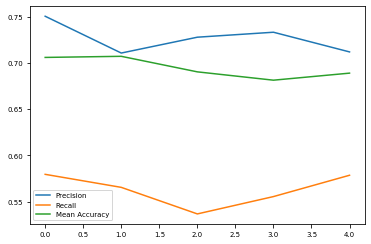

In [16]:
fig, ax = plt.subplots()
ax.plot(model['p'],label="Precision")
ax.plot(model['r'],label="Recall")
ax.plot(model['e'],label="Mean Accuracy")

plt.legend()

plt.show()

In [17]:
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


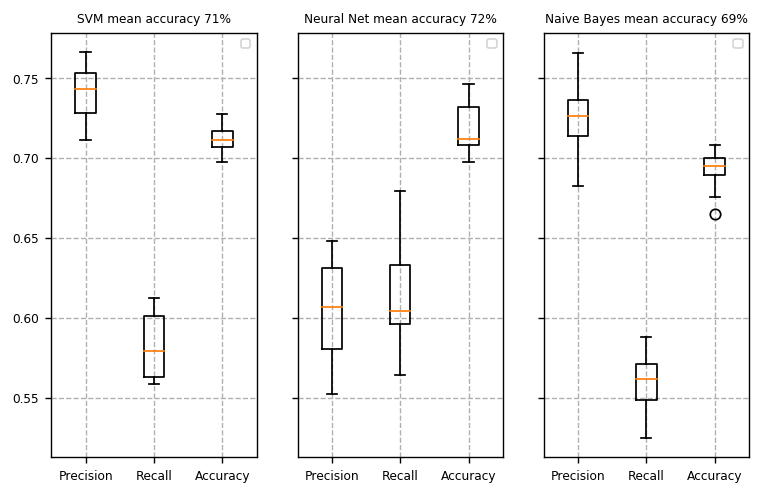

In [18]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

In [19]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

#clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [20]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

226
53956


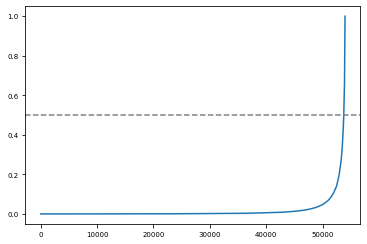

In [21]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

plt.show()

In [25]:
q = Query.objects.get(pk=qid)
q.users.all()

<QuerySet []>

In [26]:
q

<Query: published 2013+>

In [27]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

t1 = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
t1.save()

t2 = Tag(
    title="predicted relevant sample_2 {}".format(now),
    query=q
)
#t2.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 300
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5:
            print(docs_added)

    
t1.update_tag()
#t2.update_tag()

173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


In [28]:
df.to_csv(f'doctables/predictions_{now}.csv',index=False)